# Transformer Encoders

In this tutorial you will explore the **word-piece tokenization**,the **self-attention mechanism**, and how **BERT encoder** put it all together. 

## Install the libraries
If you haven't done so yet, you you need to install the following libraries:

    pip install transformers
    pip install ipywidgets
    pip install bertviz

Also, you have to download the following elements:

In [4]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Clonando para 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
A receber objetos: 100% (1633/1633), 198.37 MiB | 1.43 MiB/s, concluído.
A resolver deltas: 100% (1073/1073), concluído.


## Imports and definitions

In [1]:
import numpy as np
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')



In [2]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


# Self Attention

In [3]:
import torch
from torch.nn.functional import softmax

## Input token embeddings

In [4]:
input_embedding_dim = 4
x = [
  [1, 0, 1, 0], # Input 1
  [0, 2, 0, 2], # Input 2
  [1, 1, 1, 1], # Input 3
  [2, 0, 0, 1], # Input 4
  [0, 2, 0, 1], # Input 5
  [0, 0, 2, 1], # Input 6
  [2, 0, 1, 0], # Input 7
  [1, 2, 1, 0]  # Input 8
 ]

x = torch.tensor(x, dtype=torch.float32)


## Queries, keys and values

In [5]:
layer_embedding_dim = 2

w_key = torch.rand(layer_embedding_dim, input_embedding_dim, dtype=torch.float32)
w_query = torch.rand(layer_embedding_dim, input_embedding_dim, dtype=torch.float32)
w_value = torch.rand(layer_embedding_dim, input_embedding_dim, dtype=torch.float32)

keys = torch.matmul(x, w_key.T)
querys = torch.matmul(x, w_query.T)
values = torch.matmul(x, w_value.T)

## Scaled Dot Product Attention

In [6]:
attn_scores = torch.matmul(querys, keys.T)
attn_scores_softmax = softmax(attn_scores, dim=-1)
outputs = torch.matmul(attn_scores_softmax, values)

## Visualize the Attention Matrix

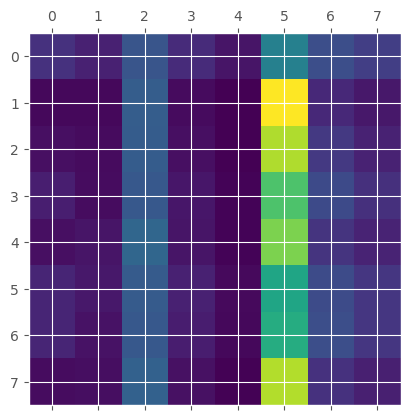

In [9]:
import matplotlib.pyplot as plt
plt.matshow(attn_scores_softmax.numpy())
plt.show()

# Pre-trained Transformer encoder models

There are many models available at HuggingFace models repository. These are stable models that were made available by researchers and the industry.

   https://huggingface.co/models

The example below is the most popular Transformer model, BERT, a cross-encoder trained on the Next Sentence Prediction task and Masked Language Model task. 

   https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/ce-msmarco.md


In [10]:
model_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
model_path = 'bert-base-uncased'
CLS_token = "[CLS]"
SEP_token = "[SEP]"

In [11]:
transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

# Input Tokenization

See here for details: https://huggingface.co/docs/transformers/tokenizer_summary

## Prepare and tokenize the input

In [37]:
sentence_a = "show me beatles albums"
sentence_b = "listen to music by the beatles"
#inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)

pprint.pprint(inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  2265,  2033, 11555,  4042,   102,  4952,  2000,  2189,  2011,
          1996, 11555,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}


## Decode the tokens

In [38]:
print(tokenizer.decode(inputs["input_ids"][0].tolist()))

[CLS] show me beatles albums [SEP] listen to music by the beatles [SEP]


## Token to Id 

In [39]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
pprint.pprint(input_id_list)

[101, 2265, 2033, 11555, 4042, 102, 4952, 2000, 2189, 2011, 1996, 11555, 102]


In [40]:
input_tokens_list = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(input_tokens_list)

['[CLS]',
 'show',
 'me',
 'beatles',
 'albums',
 '[SEP]',
 'listen',
 'to',
 'music',
 'by',
 'the',
 'beatles',
 '[SEP]']


In [27]:
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(input_id_list, input_tokens_list))
print(res)

101 	 [CLS]
2265 	 show
2033 	 me
11555 	 beatles
4042 	 albums
102 	 [SEP]
4952 	 listen
2000 	 to
2189 	 music
2011 	 by
2703 	 paul
15320 	 mccartney
102 	 [SEP]


# Model inference output

In [41]:
with torch.no_grad():
    outputs = model(**inputs)

In [42]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

## Token embeddings (per layer)

In [43]:
# total number of layers embeddings
len(outputs['hidden_states'])

13

In [44]:
# The format is as follow:
# outputs['hidden_states'][layer_m][0][token_n]
layer_m = 3
token_n = 1
# Get all the embeddings of one layer:
output_embeddings = outputs['hidden_states'][layer_m][0]

output_embeddings.shape

torch.Size([13, 768])

In [45]:
token_throat = 2
token_cancer = 3

# Get the embedding of one particular token in one particular layer
throat_output_embedding = outputs['hidden_states'][layer_m][0][token_throat]
throat_output_embedding.shape

torch.Size([768])

## Contextual word embeddings (per layer)

In [46]:
import torch
import re
from transformers import AutoTokenizer, AutoModel

def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)

def get_word_vector(inputs, outputs, idx, layer):
    """Get a word vector by averaging the embeddings of 
       all word occurrences of that word in the input"""

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == idx)
    print(inputs.word_ids())
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]
    print(token_ids_word)
    return word_tokens_output.mean(dim=0)

def get_word_vector_from_ab(inputs, outputs, word, layer = '-1', ab = 'A'):
    """
    This method extracts a word embedding from the requested layer 
    for sentence_a or sentence_b. If the word is divided into tokens, 
    the word embedding will be the average of the corresponding token 
    embeddings.

    NOTE: If the same word occurs multiple times in the sentence, 
    this method returns the word embedding of the first occurrence.

    Keyword arguments:
        inputs -- input passed to the transformer
        outputs -- output of the transformer
        word -- target word
        layer -- layer from where the word embedding vector should 
        be extracted.
        ab -- should be 'A' or 'B' indication if the word embedding is to be extracted 
        from sentence_a or sentence_b, i.e., query or document.
    """
       
    sep_token = np.where(np.array(inputs["input_ids"][0].tolist()) == 102)[0][0]
    if ab == 'A':
        tokens_a = inputs["input_ids"][0][1:sep_token]
        sent = tokenizer.decode(tokens_a.tolist())
    else:
        tokens_b = inputs["input_ids"][0][sep_token+1:-1]
        sent = tokenizer.decode(tokens_b.tolist())

    word_ids = get_word_idx(sent, word)

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == word_ids)[0]
    sep_word = np.where(np.array(inputs.word_ids()) == None)[0][1]

    if ab == 'A':
        token_pos = token_ids_word < sep_word
    else:
        token_pos = token_ids_word > sep_word
        
    token_ids_word = token_ids_word[token_pos]
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]

    # Change this to True for inspection
    details = True
    if details:
        input_id_list = input_ids[0].tolist() # Batch index 0
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        str1 = " "

        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
        print("INPUT SEQUENCE TOKENS: ", str1.join(tokens))
        print("TARGET WORD:", word)
        print("TARGET SENTENCE:", ab)
        print("TARGET SENTENCE WORDS [", sent, "]")
        print("The word [", word, "] occurs in position", idx, "of the BERT input sentence", ab)
        print("The word [", word, "] corresponds to the token(s)", token_ids_word, "of the BERT input sequence", ab)

    return word_tokens_output.mean(dim=0)



In [47]:

# The code below converts the tokens into a space delimited string.
# This will allow computing in which position of the BERT input sequence a given word is.
sentence_a = tokenizer.decode(inputs["input_ids"][0].tolist()).replace("[CLS] ", '').replace(" [SEP]", '')
word = "beatles"
idx = get_word_idx(sentence_a, word)
print("Input sequence:", sentence_a)
print("The word \"", word, "\" occurs in position", idx, "of the BERT input sequence.")

word_embedding = get_word_vector(inputs, outputs, idx, 4)

Input sequence: show me beatles albums listen to music by the beatles
The word " beatles " occurs in position 2 of the BERT input sequence.
[None, 0, 1, 2, 3, None, 0, 1, 2, 3, 4, 5, None]
(array([3, 8]),)


In [51]:
word_embedding = get_word_vector_from_ab(inputs, outputs, "beatles", 4, 'A')
word_embedding.size()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INPUT SEQUENCE TOKENS:  [CLS] show me beatles albums [SEP] listen to music by the beatles [SEP]
TARGET WORD: beatles
TARGET SENTENCE: A
TARGET SENTENCE WORDS [ show me beatles albums ]
The word [ beatles ] occurs in position 2 of the BERT input sentence A
The word [ beatles ] corresponds to the token(s) [3] of the BERT input sequence A


torch.Size([768])

## Output layer embeddings

In [52]:
# the last layer is the output embedding layer
output_embeddings = outputs['last_hidden_state']

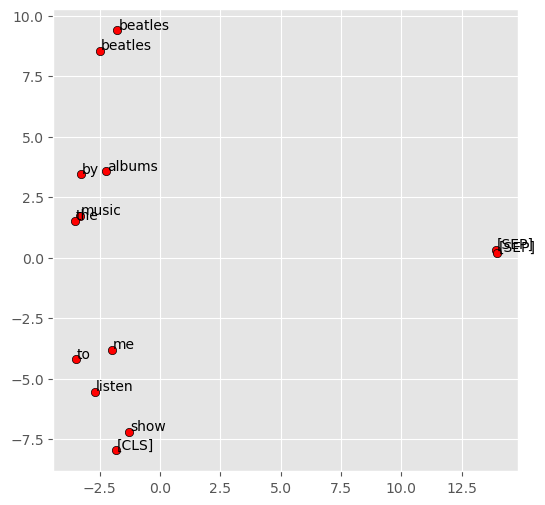

In [53]:
display_scatterplot(output_embeddings[0].detach().numpy(), input_tokens_list)

## Self-attention matrices

In [54]:
attention = outputs['attentions']

# The format of the attention tensor is:
#     attention[layer][sample_n][head][token1][token2]

layer = 3      # Transformer layer
sample_n = 0   # Input sample
head = 3       # Head of the selected layer

In [55]:
# the score of the attention of one token vs the other token
attention[layer][sample_n][head][token_throat][token_cancer]

tensor(0.0369)

In [56]:
attention[layer][sample_n][head].size()

torch.Size([13, 13])

In [57]:
# There's a softmax, so, the sum should be 1 
attention[layer][sample_n][head][token_throat].sum()

tensor(1.0000)

In [58]:
attention[layer][sample_n][head][token_cancer].sum()

tensor(1.0000)

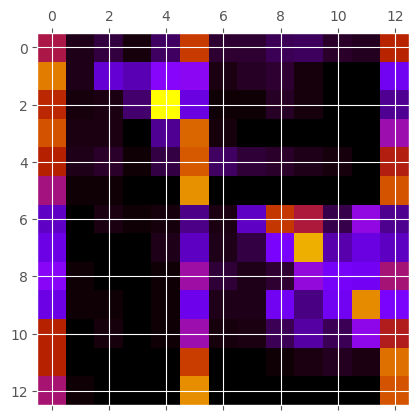

In [59]:
import matplotlib.pyplot as plt
plt.matshow(attention[layer][0][head], cmap='gnuplot')